- **Nama:** Firda Humaira
- **Email:** firdahumaira13@gmail.com
- **ID Dicoding:** firdahum

## **Import Library**

In [107]:
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
import string
import csv
import requests
from io import StringIO

# Pengaturan umum
pd.options.mode.chained_assignment = None
seed = 0
np.random.seed(seed)

# Preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt_tab')   # untuk word_tokenize
nltk.download('stopwords')   # untuk stopwords

!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Model Training & Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score

# Visualization
from wordcloud import WordCloud

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Membaca File Data yang sudah di Cleaning**

In [108]:
clean_df = pd.read_csv('ulasan_pemodelan.csv')
clean_df.head()

,content,score
0,"Saran pengembangan, tolong kembangin lagi buat pengiriman kode otp bisa melalui WhatsApp. Jujur saya keberatan jika terus-menerus harus menggunakan pulsa, karna ada suatu saat pulsa itu habis dan jarak ke konter cukup jauh.",4
1,"Setiap saya login selalu salah,, padahal baru 1kali & ID serta Passwordnya sudah benar tapi tetap saja diarahkan ke Halo BCA yg nantinya akan menarik pulsa,,Hal ini sudah sangat sering terjadi setiap kali saya login.. Aplikasi sangat buruk",1
2,"aplikasi terlalu repot, kebanyakan aplikasi. aplikasi hallo bca, aplikasi my bca. saat daftar ID sangat repot.. ingin pegaduan Hallo bca perlu login Dulu.. sedangkan saya udh mencoba daftar gagal terus sampai"" email saya 3 akun katanya sudah terdafar. saat dicek emailnya tidak terdaftar.. sangat repot dan lama makin lama, bukan mempermudah tp mempersulit.",1
3,"Tolong untuk setiap update aplikasi,agar tidak memasukkan ID, password dan OTP lagi, apalagi OTP nya lewat SMS yang itu memakan biaya, ok lah kalau misal OTP nya dikirim via WA. Atau contohlah bank2 lain, kalau aplikasinya minta update,setelah update tinggal masuk aja pakai faceID, atau sidik jari.",4
4,"Semenjak update ke tampilan baru, portofolio investasi ku di welma gak bisa di buka. Padahal di menu-menu yang lain lancar banget. Jaringan juga sudah ku gonta-ganti tapi tetep gak bisa dibuka. Lebih suka tampilan yang lama.",2


## **Preprocessing**

In [109]:
# Menghapus elemen-elemen tidak penting dari teks
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # hapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # hapus hashtag
    text = re.sub(r'RT[\s]', '', text)         # hapus RT
    text = re.sub(r"http\S+", '', text)        # hapus link
    text = re.sub(r'[0-9]+', '', text)         # hapus angka
    text = re.sub(r'[^\w\s]', '', text)        # hapus karakter khusus

    text = text.replace('\n', ' ')             # ubah newline jadi spasi
    text = text.translate(str.maketrans('', '', string.punctuation))  # hapus tanda baca
    text = text.strip()                        # hapus spasi di awal dan akhir teks
    return text

# Mengubah semua huruf menjadi huruf kecil
def casefoldingText(text):
    return text.lower()

# Memecah kalimat menjadi token (kata-kata)
def tokenizingText(text):
    return word_tokenize(text)

# Menghapus kata-kata umum (stopwords)
def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update([
        'iya', 'yaa', 'gak', 'ga', 'yaa', 'ya', 'nggak', 'ngga', 'udah', 'dah', 'aja', 'cuma', 'cmn', 'cm', 'lah', 'nih', 'sih', 'ku', 'mu', 'nya', 'deh',
        'kok', 'dong', 'padahal', 'tapi', 'tp', 'kayak', 'gitu', 'gini', 'klo', 'klw', 'kalo', 'kalau', 'biar', 'dgn', 'sama', 'pun', 'soalnya', 'soal',
        'sekarang', 'dulu', 'barusan', 'gpp', 'hehe', 'huhu', 'wkwk', 'wkwkwk', 'hadeh', 'hmm', 'lho', 'loh', 'kah', 'wew', 'huh', 'anjay', 'woy', 'woi',
        'woii'
    ])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text


# Melakukan stemming (mengembalikan kata ke bentuk dasar)
def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    words = text.split()
    stemmed = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed)

# Menggabungkan daftar kata menjadi kalimat
def toSentence(list_words):
     return ' '.join(list_words)

In [110]:
sample_text = "Saran pengembangan, tolong kembangin lagi buat pengiriman kode otp bisa melalui WhatsApp. Jujur saya keberatan jika terus-menerus harus menggunakan pulsa, karna ada suatu saat pulsa itu habis dan jarak ke konter cukup jauh."

print("Teks Asli:")
print(sample_text)
print()

# 1. Cleaning
step1 = cleaningText(sample_text)
print("Setelah Cleaning:")
print(step1)
print()

# 2. Case Folding
step2 = casefoldingText(step1)
print("Setelah Case Folding:")
print(step2)
print()

# 3. Tokenizing
step3 = tokenizingText(step2)
print("Setelah Tokenizing:")
print(step3)
print()

# 4. Filtering
step4 = filteringText(step3)
print("Setelah Filtering:")
print(step4)
print()

# 5. Gabung lagi jadi kalimat
step5 = toSentence(step4)
print("Setelah Jadi Kalimat Lagi:")
print(step5)
print()

# 6. Stemming
step6 = stemmingText(step5)
print("Setelah Stemming:")
print(step6)


Teks Asli:
Saran pengembangan, tolong kembangin lagi buat pengiriman kode otp bisa melalui WhatsApp. Jujur saya keberatan jika terus-menerus harus menggunakan pulsa, karna ada suatu saat pulsa itu habis dan jarak ke konter cukup jauh.

Setelah Cleaning:
Saran pengembangan tolong kembangin lagi buat pengiriman kode otp bisa melalui WhatsApp Jujur saya keberatan jika terusmenerus harus menggunakan pulsa karna ada suatu saat pulsa itu habis dan jarak ke konter cukup jauh

Setelah Case Folding:
saran pengembangan tolong kembangin lagi buat pengiriman kode otp bisa melalui whatsapp jujur saya keberatan jika terusmenerus harus menggunakan pulsa karna ada suatu saat pulsa itu habis dan jarak ke konter cukup jauh

Setelah Tokenizing:
['saran', 'pengembangan', 'tolong', 'kembangin', 'lagi', 'buat', 'pengiriman', 'kode', 'otp', 'bisa', 'melalui', 'whatsapp', 'jujur', 'saya', 'keberatan', 'jika', 'terusmenerus', 'harus', 'menggunakan', 'pulsa', 'karna', 'ada', 'suatu', 'saat', 'pulsa', 'itu', 'ha

In [111]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ak": "saya", "ancur": "hancur", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau","kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend","wkwkkw": "tertawa", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [112]:
clean_df

,content,score
0,"Saran pengembangan, tolong kembangin lagi buat pengiriman kode otp bisa melalui WhatsApp. Jujur saya keberatan jika terus-menerus harus menggunakan pulsa, karna ada suatu saat pulsa itu habis dan jarak ke konter cukup jauh.",4
1,"Setiap saya login selalu salah,, padahal baru 1kali & ID serta Passwordnya sudah benar tapi tetap saja diarahkan ke Halo BCA yg nantinya akan menarik pulsa,,Hal ini sudah sangat sering terjadi setiap kali saya login.. Aplikasi sangat buruk",1
2,"aplikasi terlalu repot, kebanyakan aplikasi. aplikasi hallo bca, aplikasi my bca. saat daftar ID sangat repot.. ingin pegaduan Hallo bca perlu login Dulu.. sedangkan saya udh mencoba daftar gagal terus sampai"" email saya 3 akun katanya sudah terdafar. saat dicek emailnya tidak terdaftar.. sangat repot dan lama makin lama, bukan mempermudah tp mempersulit.",1
3,"Tolong untuk setiap update aplikasi,agar tidak memasukkan ID, password dan OTP lagi, apalagi OTP nya lewat SMS yang itu memakan biaya, ok lah kalau misal OTP nya dikirim via WA. Atau contohlah bank2 lain, kalau aplikasinya minta update,setelah update tinggal masuk aja pakai faceID, atau sidik jari.",4
4,"Semenjak update ke tampilan baru, portofolio investasi ku di welma gak bisa di buka. Padahal di menu-menu yang lain lancar banget. Jaringan juga sudah ku gonta-ganti tapi tetep gak bisa dibuka. Lebih suka tampilan yang lama.",2
...,...,...
15369,Mantap,5
15370,Mantap,5
15371,good,5
15372,Suka 💙,5


In [113]:
clean_df['text_clean']            = clean_df['content'].apply(cleaningText)                 # bersihkan teks
clean_df['text_casefoldingText']  = clean_df['text_clean'].apply(casefoldingText)           # ubah ke huruf kecil
clean_df['text_slangwords']       = clean_df['text_casefoldingText'].apply(fix_slangwords)  # ganti slang
clean_df['text_tokenizingText']   = clean_df['text_slangwords'].apply(tokenizingText)       # tokenisasi
clean_df['text_stopword']         = clean_df['text_tokenizingText'].apply(filteringText)    # hapus stopwords
clean_df['text_akhir']            = clean_df['text_stopword'].apply(toSentence)             # gabungkan token jadi kalimat

In [114]:
clean_df

,content,score,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,"Saran pengembangan, tolong kembangin lagi buat pengiriman kode otp bisa melalui WhatsApp. Jujur saya keberatan jika terus-menerus harus menggunakan pulsa, karna ada suatu saat pulsa itu habis dan jarak ke konter cukup jauh.",4,Saran pengembangan tolong kembangin lagi buat pengiriman kode otp bisa melalui WhatsApp Jujur saya keberatan jika terusmenerus harus menggunakan pulsa karna ada suatu saat pulsa itu habis dan jarak ke konter cukup jauh,saran pengembangan tolong kembangin lagi buat pengiriman kode otp bisa melalui whatsapp jujur saya keberatan jika terusmenerus harus menggunakan pulsa karna ada suatu saat pulsa itu habis dan jarak ke konter cukup jauh,saran pengembangan tolong kembangin lagi buat pengiriman kode otp bisa melalui whatsapp jujur saya keberatan jika terusmenerus harus menggunakan pulsa karena ada suatu saat pulsa itu habis dan jarak ke konter cukup jauh,"[saran, pengembangan, tolong, kembangin, lagi, buat, pengiriman, kode, otp, bisa, melalui, whatsapp, jujur, saya, keberatan, jika, terusmenerus, harus, menggunakan, pulsa, karena, ada, suatu, saat, pulsa, itu, habis, dan, jarak, ke, konter, cukup, jauh]","[saran, pengembangan, tolong, kembangin, pengiriman, kode, otp, whatsapp, jujur, keberatan, terusmenerus, pulsa, pulsa, habis, jarak, konter]",saran pengembangan tolong kembangin pengiriman kode otp whatsapp jujur keberatan terusmenerus pulsa pulsa habis jarak konter
1,"Setiap saya login selalu salah,, padahal baru 1kali & ID serta Passwordnya sudah benar tapi tetap saja diarahkan ke Halo BCA yg nantinya akan menarik pulsa,,Hal ini sudah sangat sering terjadi setiap kali saya login.. Aplikasi sangat buruk",1,Setiap saya login selalu salah padahal baru kali ID serta Passwordnya sudah benar tapi tetap saja diarahkan ke Halo BCA yg nantinya akan menarik pulsaHal ini sudah sangat sering terjadi setiap kali saya login Aplikasi sangat buruk,setiap saya login selalu salah padahal baru kali id serta passwordnya sudah benar tapi tetap saja diarahkan ke halo bca yg nantinya akan menarik pulsahal ini sudah sangat sering terjadi setiap kali saya login aplikasi sangat buruk,setiap saya login selalu salah padahal baru kali id serta passwordnya sudah benar tapi tetap saja diarahkan ke halo bca yang nantinya akan menarik pulsahal ini sudah sangat sering terjadi setiap kali saya login aplikasi sangat buruk,"[setiap, saya, login, selalu, salah, padahal, baru, kali, id, serta, passwordnya, sudah, benar, tapi, tetap, saja, diarahkan, ke, halo, bca, yang, nantinya, akan, menarik, pulsahal, ini, sudah, sangat, sering, terjadi, setiap, kali, saya, login, aplikasi, sangat, buruk]","[login, salah, kali, id, passwordnya, diarahkan, halo, bca, menarik, pulsahal, kali, login, aplikasi, buruk]",login salah kali id passwordnya diarahkan halo bca menarik pulsahal kali login aplikasi buruk
2,"aplikasi terlalu repot, kebanyakan aplikasi. aplikasi hallo bca, aplikasi my bca. saat daftar ID sangat repot.. ingin pegaduan Hallo bca perlu login Dulu.. sedangkan saya udh mencoba daftar gagal terus sampai"" email saya 3 akun katanya sudah terdafar. saat dicek emailnya tidak terdaftar.. sangat repot dan lama makin lama, bukan mempermudah tp mempersulit.",1,aplikasi terlalu repot kebanyakan aplikasi aplikasi hallo bca aplikasi my bca saat daftar ID sangat repot ingin pegaduan Hallo bca perlu login Dulu sedangkan saya udh mencoba daftar gagal terus sampai email saya akun katanya sudah terdafar saat dicek emailnya tidak terdaftar sangat repot dan lama makin lama bukan mempermudah tp mempersulit,aplikasi terlalu repot kebanyakan aplikasi aplikasi hallo bca aplikasi my bca saat daftar id sangat repot ingin pegaduan hallo bca perlu login dulu sedangkan saya udh mencoba daftar gagal terus sampai email saya akun katanya sudah terdafar saat dicek emailnya tidak terdaftar sangat repot dan lama makin lama bukan mempermudah tp mempersulit,aplikasi te

## **Data Labelling**

In [115]:
# Muat kamus kata positif dari GitHub
lexicon_positive = dict()
resp = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')  # permintaan CSV
if resp.status_code == 200:
    reader = csv.reader(StringIO(resp.text), delimiter=',')  # baca CSV
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])  # simpan kata & skor
else:
    print("Failed to fetch positive lexicon data")  # error

# Muat kamus kata negatif dari GitHub
lexicon_negative = dict()
resp = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')  # permintaan CSV
if resp.status_code == 200:
    reader = csv.reader(StringIO(resp.text), delimiter=',')  # baca CSV
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])  # simpan kata & skor
else:
    print("Failed to fetch negative lexicon data")  # error

In [116]:
# Fungsi analisis sentimen menggunakan lexicon Bahasa Indonesia
def sentiment_analysis_lexicon_indonesia(text):
    score = 0  # inisialisasi skor

    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]  # tambah skor jika positif

    for word in text:
        if word in lexicon_negative:
            score += lexicon_negative[word]  # kurangi skor jika negatif

    # Tentukan polaritas: positif jika skor > 0, negatif jika skor < 0, netral jika skor == 0
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [117]:
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
clean_df['polarity'].value_counts()

,count
polarity,
negative,7143
positive,5274
neutral,2957


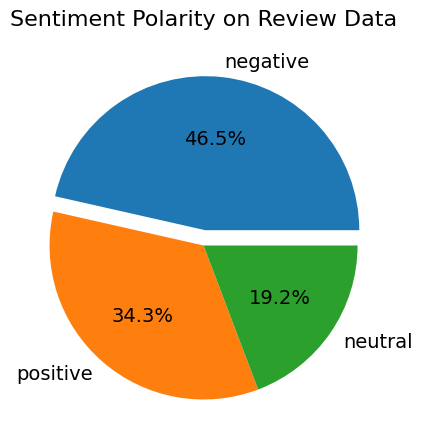

In [118]:
labels = list(clean_df['polarity'].value_counts().index)
sizes = clean_df['polarity'].value_counts().values

# Buat 'explode' array dengan panjang sama seperti jumlah kategori
import numpy as np
explode = np.zeros(len(labels))
explode[0] = 0.1  # misalnya cuma kategori pertama yang meledak

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%',
       explode=explode, textprops={'fontsize': 14})
ax.set_title('Sentiment Polarity on Review Data', fontsize=16, pad=20)
plt.show()

In [119]:
def analyze_and_visualize_tweets(clean_df):
    pd.set_option('display.max_colwidth', 3000)

    # Positive Tweets
    positive_tweets = clean_df[clean_df['polarity'] == 'positive']
    positive_tweets = positive_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
    positive_tweets = positive_tweets.sort_values(by='polarity_score', ascending=False).reset_index(drop=True)
    positive_tweets.index += 1

    # Negative Tweets
    negative_tweets = clean_df[clean_df['polarity'] == 'negative']
    negative_tweets = negative_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
    negative_tweets = negative_tweets.sort_values(by='polarity_score', ascending=True).head(10).reset_index(drop=True)
    negative_tweets.index += 1

    # Neutral Tweets
    neutral_tweets = clean_df[clean_df['polarity'] == 'neutral']
    neutral_tweets = neutral_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
    neutral_tweets = neutral_tweets.sort_values(by='polarity_score', ascending=False).reset_index(drop=True)
    neutral_tweets.index += 1

    # Word Cloud
    list_words = ''
    for tweet in clean_df['text_stopword']:
        for word in tweet:
            list_words += ' ' + word

    wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title('Word Cloud of Tweets Data', fontsize=18)
    ax.grid(False)
    ax.imshow(wordcloud)
    fig.tight_layout(pad=0)
    ax.axis('off')
    plt.show()

    return positive_tweets, negative_tweets, neutral_tweets


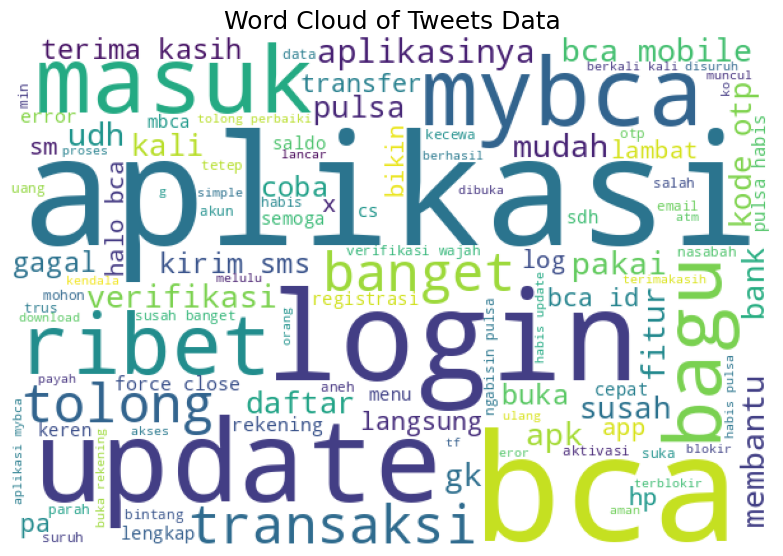

In [120]:
positive_tweets, negative_tweets, neutral_tweets = analyze_and_visualize_tweets(clean_df)

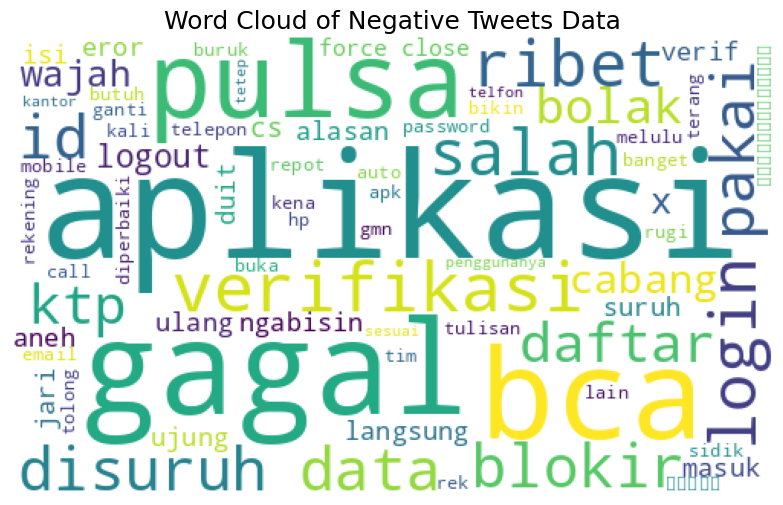

In [121]:
# Kumpulkan semua kata dari tweet negatif
list_words = ''
for tweet in negative_tweets['text_stopword']:
    for word in tweet:
        list_words += ' ' + word

# Buat WordCloud dari kata-kata yang terkumpul
wordcloud = WordCloud(width=500, height=300, background_color='white', min_font_size=10).generate(list_words)

# Tampilkan WordCloud
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Negative Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow(wordcloud)
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

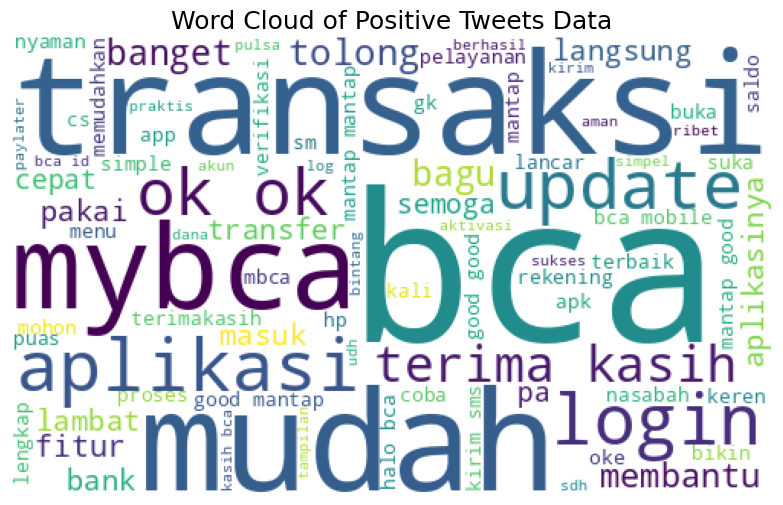

In [122]:
# Kumpulkan semua kata dari tweet positif
list_words = ''
for tweet in positive_tweets['text_stopword']:
    for word in tweet:
        list_words += ' ' + word

# Buat dan tampilkan WordCloud
wordcloud = WordCloud(width=500, height=300, background_color='white', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Positive Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow(wordcloud)
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

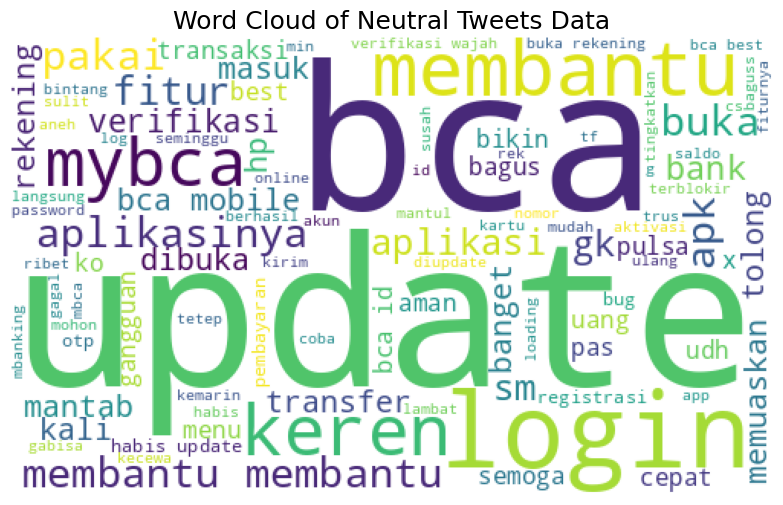

In [123]:
# Kumpulkan semua kata dari tweet netral
list_words = ''
for tweet in neutral_tweets['text_stopword']:
    for word in tweet:
        list_words += ' ' + word

# Buat dan tampilkan WordCloud
wordcloud = WordCloud(width=500, height=300, background_color='white', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Neutral Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow(wordcloud)
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

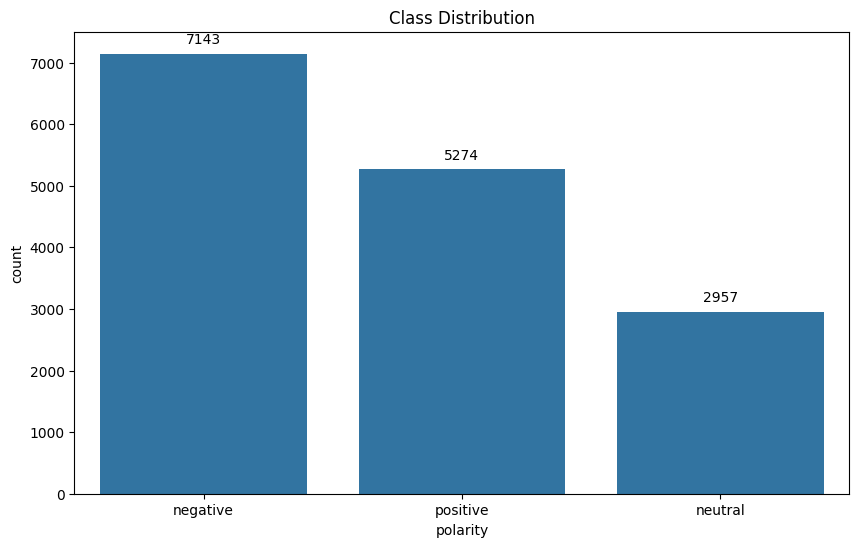

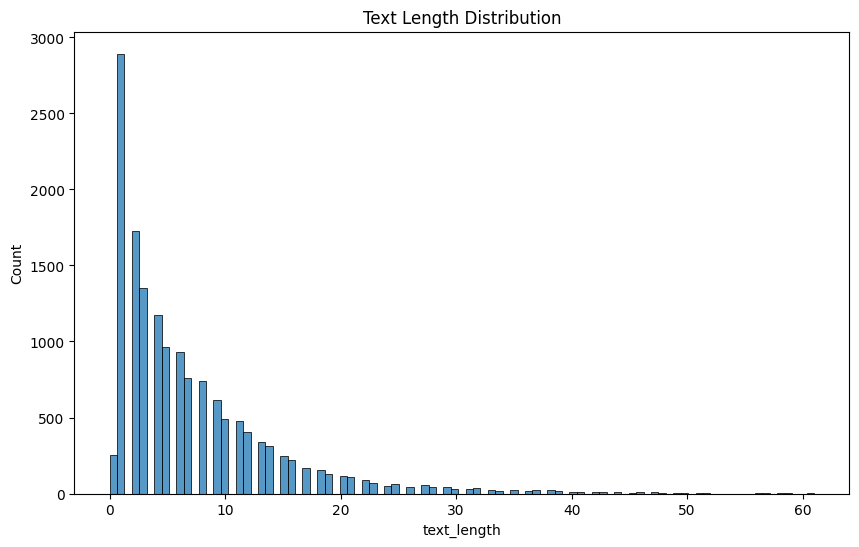

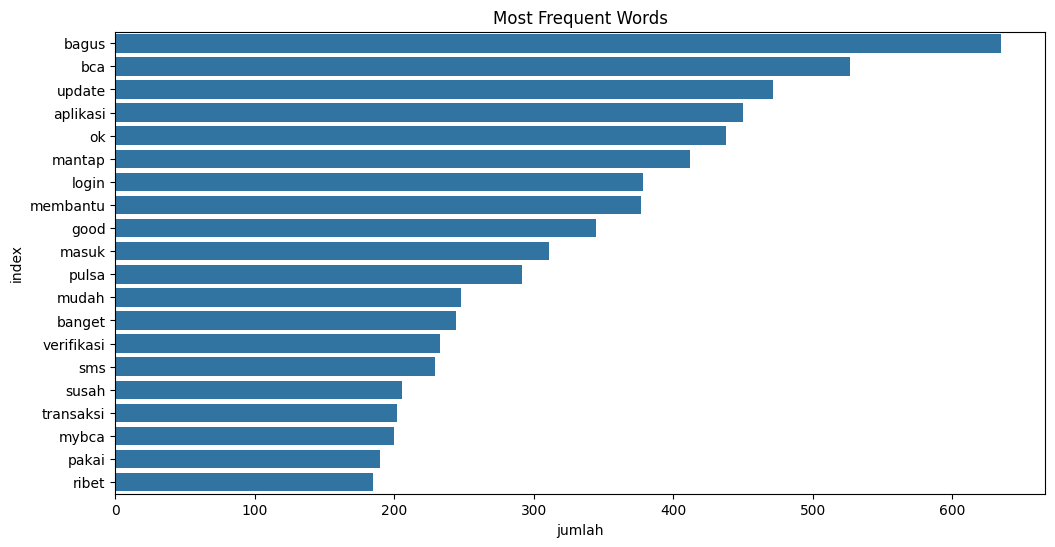

In [124]:
# Visualisasi Distribusi Kelas Sentimen
plt.figure(figsize=(10, 6))
class_dist_plot = sns.countplot(x='polarity', data=clean_df)
plt.title('Class Distribution')

# Menampilkan jumlah pada masing-masing bar
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                             (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='center',
                             xytext=(0, 10),
                             textcoords='offset points')
plt.show()

# Visualisasi Panjang Teks Review
plt.figure(figsize=(10, 6))
clean_df['text_length'] = clean_df['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(clean_df['text_length'])
plt.title('Text Length Distribution')
plt.show()

# Visualisasi Kata yang Paling Sering Muncul
plt.figure(figsize=(12, 6))
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_df['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

## **Data Splitting**

In [125]:
clean_df.head(2)

,content,score,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity,text_length
0,"Saran pengembangan, tolong kembangin lagi buat pengiriman kode otp bisa melalui WhatsApp. Jujur saya keberatan jika terus-menerus harus menggunakan pulsa, karna ada suatu saat pulsa itu habis dan jarak ke konter cukup jauh.",4,Saran pengembangan tolong kembangin lagi buat pengiriman kode otp bisa melalui WhatsApp Jujur saya keberatan jika terusmenerus harus menggunakan pulsa karna ada suatu saat pulsa itu habis dan jarak ke konter cukup jauh,saran pengembangan tolong kembangin lagi buat pengiriman kode otp bisa melalui whatsapp jujur saya keberatan jika terusmenerus harus menggunakan pulsa karna ada suatu saat pulsa itu habis dan jarak ke konter cukup jauh,saran pengembangan tolong kembangin lagi buat pengiriman kode otp bisa melalui whatsapp jujur saya keberatan jika terusmenerus harus menggunakan pulsa karena ada suatu saat pulsa itu habis dan jarak ke konter cukup jauh,"[saran, pengembangan, tolong, kembangin, lagi, buat, pengiriman, kode, otp, bisa, melalui, whatsapp, jujur, saya, keberatan, jika, terusmenerus, harus, menggunakan, pulsa, karena, ada, suatu, saat, pulsa, itu, habis, dan, jarak, ke, konter, cukup, jauh]","[saran, pengembangan, tolong, kembangin, pengiriman, kode, otp, whatsapp, jujur, keberatan, terusmenerus, pulsa, pulsa, habis, jarak, konter]",saran pengembangan tolong kembangin pengiriman kode otp whatsapp jujur keberatan terusmenerus pulsa pulsa habis jarak konter,-8,negative,16
1,"Setiap saya login selalu salah,, padahal baru 1kali & ID serta Passwordnya sudah benar tapi tetap saja diarahkan ke Halo BCA yg nantinya akan menarik pulsa,,Hal ini sudah sangat sering terjadi setiap kali saya login.. Aplikasi sangat buruk",1,Setiap saya login selalu salah padahal baru kali ID serta Passwordnya sudah benar tapi tetap saja diarahkan ke Halo BCA yg nantinya akan menarik pulsaHal ini sudah sangat sering terjadi setiap kali saya login Aplikasi sangat buruk,setiap saya login selalu salah padahal baru kali id serta passwordnya sudah benar tapi tetap saja diarahkan ke halo bca yg nantinya akan menarik pulsahal ini sudah sangat sering terjadi setiap kali saya login aplikasi sangat buruk,setiap saya login selalu salah padahal baru kali id serta passwordnya sudah benar tapi tetap saja diarahkan ke halo bca yang nantinya akan menarik pulsahal ini sudah sangat sering terjadi setiap kali saya login aplikasi sangat buruk,"[setiap, saya, login, selalu, salah, padahal, baru, kali, id, serta, passwordnya, sudah, benar, tapi, tetap, saja, diarahkan, ke, halo, bca, yang, nantinya, akan, menarik, pulsahal, ini, sudah, sangat, sering, terjadi, setiap, kali, saya, login, aplikasi, sangat, buruk]","[login, salah, kali, id, passwordnya, diarahkan, halo, bca, menarik, pulsahal, kali, login, aplikasi, buruk]",login salah kali id passwordnya diarahkan halo bca menarik pulsahal kali login aplikasi buruk,-12,negative,14


In [126]:
def prepare_features(clean_df):
    # Pisahkan data menjadi fitur dan label
    X = clean_df['text_akhir']
    y = clean_df['polarity']

    # Ekstraksi fitur TF-IDF
    tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8)
    X_tfidf = tfidf.fit_transform(X)

    # Buat dataframe dari hasil ekstraksi
    features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

    # Split data ke training dan testing
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

    return X, y, tfidf, X_tfidf, features_df, X_train, X_test, y_train, y_test

In [127]:
X, y, tfidf, X_tfidf, features_df, X_train, X_test, y_train, y_test = prepare_features(clean_df)

### **Pemodelan**

In [128]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    # Naive Bayes
    naive_bayes = BernoulliNB()
    naive_bayes.fit(X_train.toarray(), y_train)
    y_pred_train_nb = naive_bayes.predict(X_train.toarray())
    y_pred_test_nb = naive_bayes.predict(X_test.toarray())
    accuracy_train_nb = accuracy_score(y_pred_train_nb, y_train)
    accuracy_test_nb = accuracy_score(y_pred_test_nb, y_test)
    print('Naive Bayes - train:', accuracy_train_nb, '| test:', accuracy_test_nb)

    # Random Forest
    random_forest = RandomForestClassifier()
    random_forest.fit(X_train.toarray(), y_train)
    y_pred_train_rf = random_forest.predict(X_train.toarray())
    y_pred_test_rf = random_forest.predict(X_test.toarray())
    accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train)
    accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test)
    print('Random Forest - train:', accuracy_train_rf, '| test:', accuracy_test_rf)

    # Logistic Regression
    logistic_regression = LogisticRegression()
    logistic_regression.fit(X_train.toarray(), y_train)
    y_pred_train_lr = logistic_regression.predict(X_train.toarray())
    y_pred_test_lr = logistic_regression.predict(X_test.toarray())
    accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)
    accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)
    print('Logistic Regression - train:', accuracy_train_lr, '| test:', accuracy_test_lr)

    # Decision Tree
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(X_train.toarray(), y_train)
    y_pred_train_dt = decision_tree.predict(X_train.toarray())
    y_pred_test_dt = decision_tree.predict(X_test.toarray())
    accuracy_train_dt = accuracy_score(y_pred_train_dt, y_train)
    accuracy_test_dt = accuracy_score(y_pred_test_dt, y_test)
    print('Decision Tree - train:', accuracy_train_dt, '| test:', accuracy_test_dt)


In [129]:
train_and_evaluate_models(X_train, X_test, y_train, y_test)

Naive Bayes - train: 0.7646150093503536 | test: 0.7557723577235772
Random Forest - train: 0.9523538499064964 | test: 0.8286178861788618
Logistic Regression - train: 0.8679567444507683 | test: 0.847479674796748
Decision Tree - train: 0.9523538499064964 | test: 0.7850406504065041


In [130]:
def evaluate_models():
    models = {
        'Naive Bayes': BernoulliNB(),
        'Random Forest': RandomForestClassifier(),
        'Logistic Regression': LogisticRegression(),
        'Decision Tree': DecisionTreeClassifier()
    }

    results = []
    for name, model in models.items():
        model.fit(X_train.toarray(), y_train)
        acc_test = accuracy_score(model.predict(X_test.toarray()), y_test)
        results.append([name, acc_test])

    df = pd.DataFrame(results, columns=['Model', 'Accuracy Test'])
    return df

In [131]:
evaluate_models()

,Model,Accuracy Test
0,Naive Bayes,0.755772
1,Random Forest,0.833821
2,Logistic Regression,0.847480
3,Decision Tree,0.785691


In [132]:
def evaluate_models():
    models = {
        'Naive Bayes': BernoulliNB(),
        'Random Forest': RandomForestClassifier(),
        'Logistic Regression': LogisticRegression(),
        'Decision Tree': DecisionTreeClassifier()
    }

    results = []
    for name, model in models.items():
        model.fit(X_train.toarray(), y_train)
        acc_test = accuracy_score(model.predict(X_test.toarray()), y_test)
        results.append([name, acc_test])

    df = pd.DataFrame(results, columns=['Model', 'Accuracy Test'])
    df = df.sort_values(by='Accuracy Test', ascending=False).reset_index(drop=True)
    return df

In [133]:
evaluate_models()

,Model,Accuracy Test
0,Logistic Regression,0.847480
1,Random Forest,0.831220
2,Decision Tree,0.786341
3,Naive Bayes,0.755772


Dalam kasus Sentiment Analysis ini, algoritma Naive Bayes mencapai akurasi tertinggi sebesar 87,27%. Oleh karena itu, algoritma Naive Bayes dipilih sebagai model utama yang akan digunakan untuk memprediksi sentimen pada kalimat-kalimat baru.

In [134]:
# Inisialisasi dan latih model
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train.toarray(), y_train)

LogisticRegression()

In [135]:
# Input kalimat dari pengguna
kalimat_baru = input("Masukkan kalimat baru: ")

# Preprocessing
kalimat_baru = cleaningText(kalimat_baru)
kalimat_baru = casefoldingText(kalimat_baru)
kalimat_baru = fix_slangwords(kalimat_baru)
kalimat_baru = tokenizingText(kalimat_baru)
kalimat_baru = filteringText(kalimat_baru)
kalimat_baru = toSentence(kalimat_baru)

# TF-IDF transform
X_baru = tfidf.transform([kalimat_baru])

# Prediksi sentimen
hasil_prediksi = logistic_regression.predict(X_baru)

# Tampilkan hasil
if hasil_prediksi[0] == 'positive':
    print("Sentimen kalimat baru adalah POSITIF.")
elif hasil_prediksi[0] == 'negative':
    print("Sentimen kalimat baru adalah NEGATIF.")
else:
    print("Sentimen kalimat baru adalah NETRAL.")

Masukkan kalimat baru: lumayan lah
Sentimen kalimat baru adalah NETRAL.
